# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [34]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   1.0.0
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Connect to DB, load data, clean data

In [28]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [29]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT 
        package_id, 
        from_id, 
        to_id, 
        (from_semver).major AS from_semver_major, 
        (from_semver).minor AS from_semver_minor, 
        (from_semver).bug AS from_semver_bug,
        (to_semver).major AS to_semver_major, 
        (to_semver).minor AS to_semver_minor, 
        (to_semver).bug AS to_semver_bug,
        from_created,
        to_created,
        ty
    FROM analysis.all_updates
")

In [30]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- as.factor(all_updates$ty)

In [31]:
head(all_updates)

,package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,tyFact
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<fct>
1,1412915,9018365,9018366,1,0,1,1,0,2,2019-10-15 09:33:48,2019-10-15 09:41:41,bug,bug
2,1412915,9018366,9018367,1,0,2,1,1,0,2019-10-15 09:41:41,2019-10-15 09:45:24,minor,minor
3,1412915,9018367,9018368,1,1,0,1,1,1,2019-10-15 09:45:24,2019-10-15 10:10:43,bug,bug
4,1412917,9018370,9018371,1,0,0,1,0,1,2021-04-03 19:33:36,2021-04-04 20:59:03,bug,bug
5,1412917,9018371,9018372,1,0,1,1,0,2,2021-04-04 20:59:03,2021-04-04 21:04:16,bug,bug
6,1412917,9018372,9018373,1,0,2,1,0,3,2021-04-04 21:04:16,2021-04-04 21:09:14,bug,bug


# Make plots!

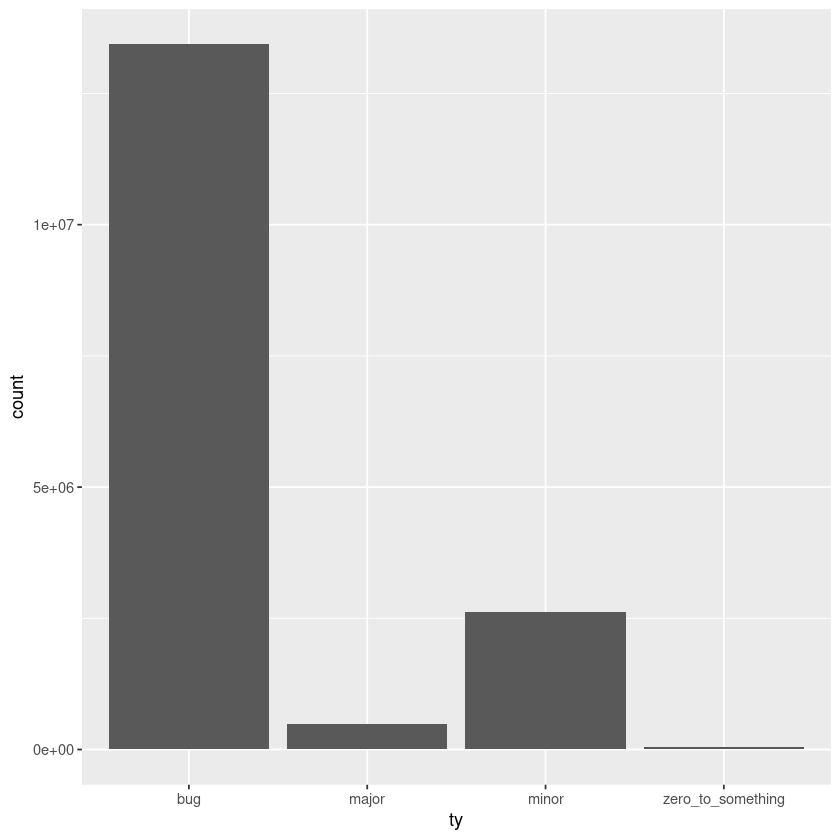

In [32]:
# Takes about 20 seconds
ggplot(data = all_updates, aes(x = ty)) +
    geom_bar()

### What proportion of each package's update are each type?

In [43]:
# creates a data frame with one row per package, and columns for count of each update type
updateCountsByPackage <- all_updates %>%
    group_by(package_id,tyFact) %>%
    summarise(
        count = n()
    ) %>% 
    pivot_wider(names_from = tyFact, values_from = count, values_fill=0) %>%
    mutate(total = bug + major + minor + zero_to_something,
           bugPct = bug / total,
           majorPct = major / total,
           minorPct = minor / total,
           zeroPct = zero_to_something / total
    )

`summarise()` has grouped output by 'package_id'. You can override using the
`.groups` argument.


In [52]:
# make a long version of it for ggplot
updateCountsByPackageLong <- updateCountsByPackage %>%
    pivot_longer(cols=ends_with("Pct"), names_to="ty", values_to="pct")

In [53]:
head(updateCountsByPackageLong)

package_id,bug,major,minor,zero_to_something,total,ty,pct
<int64>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>
335,150,12,182,0,344,bugPct,0.43604651
335,150,12,182,0,344,majorPct,0.03488372
335,150,12,182,0,344,minorPct,0.52906977
335,150,12,182,0,344,zeroPct,0.00000000
336,2,0,0,1,3,bugPct,0.66666667
336,2,0,0,1,3,majorPct,0.00000000


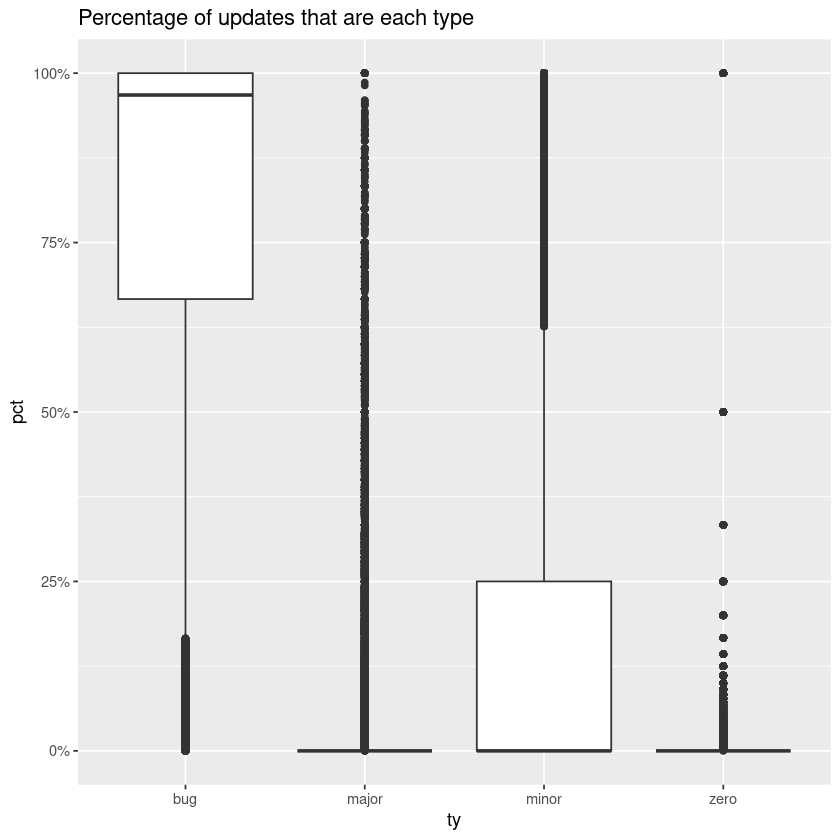

In [59]:
# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = ty, y = pct)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    scale_x_discrete(labels=c("bug", "major", "minor", "zero")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(title = "Percentage of updates that are each type")

package_id,major,minor,bug,none,total,majorPct,minorPct,bugPct,nonePct
<int64>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
335,12,182,150,0,344,0.03488372,0.5290698,0.4360465,0
336,0,0,2,0,3,0.00000000,0.0000000,0.6666667,0
337,0,0,1,0,1,0.00000000,0.0000000,1.0000000,0
341,18,233,384,0,635,0.02834646,0.3669291,0.6047244,0
488,1,0,1,0,2,0.50000000,0.0000000,0.5000000,0
2580,0,1,2,0,3,0.00000000,0.3333333,0.6666667,0
